<p style="font-size:34px;text-align:center"> <b> Personalized Cancer Diagnosis </b></p>

<h1>1. Business Problem </h1>

<h2>1.1. Description and Details </h2><br>

<p> <b>Source</b>: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p><br>
<p> <b>Data</b>: Memorial Sloan Kettering Cancer Center (MSKCC). Download the training text and training variant data from kaggle.</p><br>
<p> <b>My Understanding</b>:</p>
<p>  There are various types of genes and for each gene there are variations. So each individual, what gene and variation they have, the individual can be classified in nine categories. And some of these classes lead to some kind of cancer.</p>
<p>The workflow is as follows:</p>
<p>1. A molecular pathologist selects a list of genetic variations of interest that he/she want to analyze</p>
<p>2. The molecular pathologist searches for evidence in the medical literature that is relevant to the genetic variations of interest.</p>
<p>3. Finally this molecular pathologist spends huge amount of time analyzing the evidence related to each of the variations to classify them into one of the nine categories.</p>
<p></p>
<p><b>My Goal</b> is to replace the step 3 with a ML Model. The molecular pathologist will still have to decide which variations are of interest, and also collect the relevant evidence for them. but the last step, which is also the most time consuming will be fully automated.</p>
<br>
<p><b>Problem statement:</b></p>
<p> Classify the given variations/mutations based on evidence from text-based clinical literature</p>

<h2>1.2 Business Objectives and Constraints</h2> 

* Low Latency requirement is not there. (Time is not a constraint)
* Interpretation of our decision by doctors is important because it is a question of life and death
* Errors can be really costly so our focus should be on least errors
* Probabilty of a data point belonging to each class is needed

<h1>2. Machine Learning Problem Formulation</h1>
<h2>2.1 Data </h2>
<h3>2.1.1. Overview</h3>


- We have 2 files, one of them contains the information about the genetic mutations and the other about the clinical evidence (text) that pathologists use to classify the genetic mutations
- The files have a common field of ID

- <p> Data file information:
    <ul> 
        <li> 
            training_variants (ID, Gene, Variations, Class)
        </li>
        <li>
            training_text (ID, Text)
        </li>
    </ul>
</p>    
- Thus we perform the join operation on two data to get all the data at one place

<h3>2.1.2. Example Data Points</h3>

<h6> Training_Variants</h6>
<hr>
ID, Gene, Variation, Class<br>
6	CBL	V430M	5<br>
7	CBL	Deletion	1<br>
8	CBL	Y371H	4<br>
9	CBL	C384R	4<br>
.
<h6> Training_text </h6>
<hr>
ID, Text <br>
6	CBL	V430M	5
7	CBL	Deletion	1
8	CBL	Y371H	4
9	CBL	C384R	4

<h2>2.2. Mapping the real-world problem to an ML problem</h2><br>

<h3>2.2.1. Type of Machine Learning Problem</h3>
<p>
        There are nine different classes a genetic mutation (gene and variation) can be classified into => A Multi Class Classfication Problem
</p>    

<h3>2.2.2. Performance Metric</h3>


As mentioned on kaggle https://www.kaggle.com/c/msk-redefining-cancer-treatment/overview/evaluation :<br>
 <b>Metric(s):</b>
* Multiclass Log-loss
* Confusion Matrix

And it is exactly what should be selected, reason being, in Log Loss we use the exact probability for a datapoint i to belong to each class. i.e what is the probability that it belongs to class 1,2,3,4..,9 and then we compute the loss. 

<h3>2.2.3. Machine Learning Objectives and Constraints</h3>

<p><b>Objective:</b> Predict the probability of each data-point belonging to each of the nine classes.<br><br>
    <b>Constraints:</b><br></p>   
    <ul>
    <li>Interpretability</li>
    <li>Class probabilities are needed</li>
    <li>Penalize the errors in class probabilities => Metric is Log-Loss</li>
    <li>No Latency Constraints</li>
    </ul>
 

<h2>2.3. Train, CV and Test Datasets</h2>

<p>We can observe that there is no temporal, time based feature present in our data. Thus, Split the dataset randomly into three parts train, cross validation and test with 64%, 16% and 20% of data respectively</p>

<h1>3. Exploratory Data Analysis</h1>

In [1]:
conda install mlxtend --channel conda-forge

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - mlxtend


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.3               |   py38h50d1736_2         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following packages will be UPDATED:

  conda                               4.10.3-py38h50d1736_0 --> 4.10.3-py38h50d1736_2



conda-4.10.3         | 3.1 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda update -n base -c defaults conda

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - conda


The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.10.3-py38h50d173~ --> pkgs/main::conda-4.10.3-py38hecd8cb5_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install -c conda-forge imbalanced-learn

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    imbalanced-learn-0.8.1     |     pyhd8ed1ab_0         110 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         110 KB

The following packages will be UPDATED:

  conda              pkgs/main::conda-4.10.3-py38hecd8cb5_0 --> conda-forge::conda-4.10.3-py38h50d1736_2
  imbalanced-learn                       0.8.0-pyhd8ed1ab_0 --> 0.8.1-pyhd8ed1ab_0



imbalanced-learn-0.8 | 110 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit_learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as p
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as n
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
#from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
#from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

<h2>3.1 Reading Data </h2>

<h3>3.1.1. Reading Gene and Variation Data</h3>

<p> 
    Training/Training_variants is a comma separated file containing the description of the genetic mutations used for training.<br>
    Fields are:
    <ul>
        <li><b>ID : </b>The id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b> The gene where the genetic mutation is located</li>
        <li><b>Variation : </b>The aminoacid change for this mutations</li>
        <li><b>Class : </b>1-9th class this genetic mutation has been classified on</li>
    </ul>
        

In [6]:
data=p.read_csv("training_variants")
print("Training Variants Shape:",data.shape)
print("Feature names:",data.columns.values)
data.head(10)

Training Variants Shape: (3321, 4)
Feature names: ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [7]:
null_cols=data.columns[data.isnull().any()]
print(data[null_cols].isnull().sum())

Series([], dtype: float64)


<h3>3.1.2. Reading Text Data</h3>

<p>Here the separator is || not comma so we need to specify it while reading the data </p>

In [8]:
#Here we need to provide name of columns explicitly because ID,Text are comma separated. And we skip first row
data_text=p.read_csv("training_text",sep="\|\|",names=['ID','Text'],skiprows=1)
print("Training Text data shape:",data_text.shape)
data_text.head()

Training Text data shape: (3321, 2)


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>3.1.3. Preprocessing of Text Begins</h3>

In [9]:
str1="Here is a string %6 534 @"
str1=re.sub('[^A-Za-z0-9]+', ' ', str1)

In [10]:
re.sub('\s+',' ',str1)

'Here is a string 6 534 '

In [11]:
#for index,row in data_text.iterrows():
#    print(type(row['Text']))

In [12]:
import nltk
nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sudhanshurai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stop_words=set(stopwords.words('english'))
print(stop_words)

def text_cleaning(text, index):
    if type(text) is not int:
        string=""
        text=re.sub('[^A-Za-z0-9]+', ' ', text)
        text=re.sub('\s+',' ',text)
        text=text.lower()
        
        for word in text.split():
            if not word in stop_words:
                string+=word+" "
        data_text['Text'][index]=string        

{'other', 'has', "you've", 'until', 'is', 'why', 'not', 'have', 'being', 'with', 'each', "should've", 'itself', 'out', 'above', 'too', 'm', 'do', 'can', "you're", 'our', 'what', 'it', 'd', 'before', 'same', 'having', 'this', "that'll", 'we', 'the', 'themselves', 'between', "mightn't", 'shan', 'mustn', 'will', "hasn't", 'here', 'wouldn', 'again', 'only', 'or', 'their', 'which', 'through', 'about', 'as', 'he', 'some', 'who', 'a', 'where', 'doing', 'its', 'now', 'hasn', 'then', 'own', 'more', 'further', "couldn't", 'was', 'yours', 'herself', "doesn't", 't', 'no', 'should', "wasn't", 'didn', 'when', 'during', 'but', 'i', 'than', 'his', "you'll", 'be', "it's", 'couldn', 'she', 'all', 'hadn', 's', 'whom', 'himself', 'haven', 'for', 'below', 'under', 'by', 'that', "needn't", 'of', 'an', 'any', 'down', 'had', 'to', 'theirs', 'if', 'and', 'don', 'shouldn', 'nor', 'yourselves', 'me', 'll', 'needn', 'after', "don't", 'ours', 'mightn', 'her', 'against', 'up', 'once', 'am', 'most', 'weren', 'you', 

In [14]:
for index,row in data_text.iterrows():
    if type(row['Text']) is str:
        text_cleaning(row['Text'],index)
    else:
        print("No text found in text column of row:",index)

No text found in text column of row: 1109
No text found in text column of row: 1277
No text found in text column of row: 1407
No text found in text column of row: 1639
No text found in text column of row: 2755


In [84]:
#first 500 characters in 1st index

data_text['Text'][0][0:500]

'cyclin dependent kinases cdks regulate variety fundamental cellular processes cdk10 stands one last orphan cdks activating cyclin identified kinase activity revealed previous work shown cdk10 silencing increases ets2 v ets erythroblastosis virus e26 oncogene homolog 2 driven activation mapk pathway confers tamoxifen resistance breast cancer cells precise mechanisms cdk10 modulates ets2 activity generally functions cdk10 remain elusive demonstrate cdk10 cyclin dependent kinase identifying cyclin '

In [16]:
#now we will combine our two different datasets and save the cleaned data into new csv file
processed_data=p.merge(data,data_text, on='ID',how='left')
processed_data.head()
processed_data.to_csv('processed_data.csv')

In [17]:
#now we are reading our processed data as data

In [18]:
data=p.read_csv('processed_data.csv')

In [19]:
data.head()

,Unnamed: 0,ID,Gene,Variation,Class,Text
0,0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [20]:
#we observed that there are a few rows in which text data is blank. so we just enter the gene name and variation in these fields
data[data.isnull().any(axis=1)]

,Unnamed: 0,ID,Gene,Variation,Class,Text
1109,1109,1109,FANCA,S1088F,1,NaN
1277,1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,1407,FGFR3,K508M,6,NaN
1639,1639,1639,FLT1,Amplification,6,NaN
2755,2755,2755,BRAF,G596C,7,NaN


In [21]:
data.loc[data['Text'].isnull(),'Text']=data['Gene']+' '+data['Variation']
data[data['ID']==2755]

,Unnamed: 0,ID,Gene,Variation,Class,Text
2755,2755,2755,BRAF,G596C,7,BRAF G596C


<h3>3.1.4. Train, Test and Cross Validation Split</h3>
<p> We will break our data first in 80-20 ratio into Train and Test and then 80% of Train data will be further broken into 80:20 ratio for Train and Cross Validation data. Thus making the Train:Test:CV ratio as 64:20:16.</p><p> This is just random break, you can choose whatever ratio you like.</p>
<br>
<p>Before breaking our data, we need to make sure that if the data is imbalanced, then the test, train and CV data should have the same proportion of different class labels as the original data. For this we have <b>stratify</b> variable in train_test_split method, where we pass the class label values and our data is broken in exact proportionality.</p>

In [22]:
class_data=data['Class'].values

X_train, X_test, y_train, y_test=train_test_split(data,class_data,stratify=class_data,test_size=0.2)
X_train, X_cv, y_train, y_cv=train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

print("Total points in X_train is:",X_train.shape[0])
print("Total points in X_test is:",X_test.shape[0])
print("Total points in X_cv is:",X_cv.shape[0])

Total points in X_train is: 2124
Total points in X_test is: 665
Total points in X_cv is: 532


<h6>3.1.4.2 Validation of Proportionality in which Data is broken</h6>
<p> Here we plot the bar graph for each distribution and check if each class label is equally distributed in each category.</p>


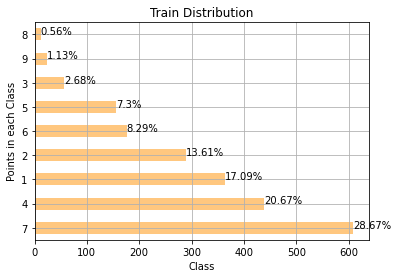

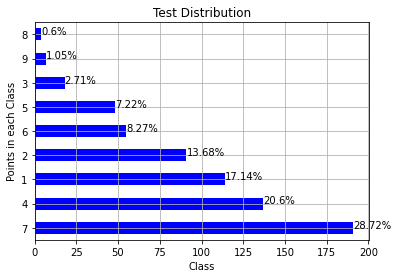

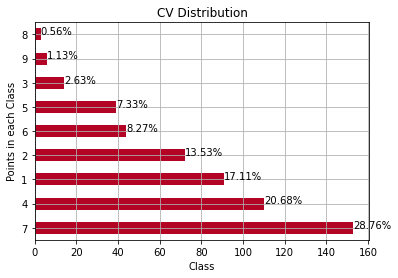

In [23]:
train_dist=X_train['Class'].value_counts()
test_dist=X_test['Class'].value_counts()
cv_dist=X_cv['Class'].value_counts()

train_dist.plot(kind='barh',colormap='copper_r')
plt.xlabel('Class')
plt.ylabel('Points in each Class')
plt.title('Train Distribution')
plt.grid()
for index,value in enumerate(train_dist):
    s=n.round(value/X_train.shape[0]*100,2)
    s1=str(s)+"%"
    plt.text(value, index, s1)
plt.show()


test_dist.plot(kind='barh',colormap='winter')
plt.xlabel('Class')
plt.ylabel('Points in each Class')
plt.title('Test Distribution')
plt.grid()
for index,value in enumerate(test_dist):
    s=n.round(value/X_test.shape[0]*100,2)
    s1=str(s)+"%"
    plt.text(value, index, s1)
plt.show()


cv_dist.plot(kind='barh',colormap='coolwarm_r')
plt.xlabel('Class')
plt.ylabel('Points in each Class')
plt.title('CV Distribution')
plt.grid()
for index,value in enumerate(cv_dist):
    s=n.round(value/X_cv.shape[0]*100,2)
    s1=str(s)+"%"
    plt.text(value, index, s1)
plt.show()



<p><b>NOTE:</b> It can be observed that all the three distributions are almost equal by the proportion of the class labels. For example we can see that for class label 1, train, test and CV distributions have 17.09%, 17.14% and 17.11% of class label 1 respectively. </p>

In [24]:
import numpy as n
t=n.random.rand(1,9)
z=((t/sum(sum(t))))
print(z[0])
print(z)

[0.04740126 0.18115874 0.14263622 0.13961517 0.02472206 0.06951812
 0.08105514 0.14076486 0.17312843]
[[0.04740126 0.18115874 0.14263622 0.13961517 0.02472206 0.06951812
  0.08105514 0.14076486 0.17312843]]


<h2>3.2 Random Model</h2>

In [25]:
z=n.zeros((X_cv.shape[0],9)).shape
print(X_cv.shape[0])
print(z)

532
(532, 9)


<p>In case of log loss, the range of possible values is [0,infinity) where 0 depicts the ideal model and a very high value depicts a random model. To find the upper limit, we generate random values as predicted values and compute its log loss so that we can have the upper limit of log loss. </p><p>We will compute nine random class probabilites for each class such that their sum is equal to one.</p>

In [26]:
#we find number of rows in cv and test data
len_X_cv=X_cv.shape[0]
len_X_test=X_test.shape[0]

#we create a output array that has exactly same size as the CV data
#Log_Loss: In Log loss we compute the (-1/n)summation summation(yij*log(pij)). since we have multiclass classification,
#yij is equal to 1 for correct class label, and for others its equal to 0. and we multiply it with predicted probability of
#that class label. so if the prob is high, log value will be less. If the prob for correct class label is low, then the log 
#value will be high. That is why we need log loss as less as possible. 


predicted_y_cv=n.zeros((len_X_cv,9))
predicted_y_test=n.zeros((len_X_test,9))


for i in range(len_X_cv):
    random_prob=n.random.rand(1,9)
    predicted_y_cv[i]=random_prob/sum(sum(random_prob))
print("Log Loss from Random generated model for CV data is :",log_loss(y_cv,predicted_y_cv))


for i in range(len_X_test):
    random_probs=n.random.rand(1,9)
    predicted_y_test[i]=random_probs/sum(sum(random_probs))
print("Log Loss from Random generated model for Test data is :",log_loss(y_test,predicted_y_test))


Log Loss from Random generated model for CV data is : 2.433361642514594
Log Loss from Random generated model for Test data is : 2.463658543176358


In [27]:
#Confusion matrix where x axis is Predicted Class, and y axis is Original Class
confusion_matrix(y_test, n.argmax(predicted_y_test,axis=1)+1) 

array([[13, 14, 15, 15, 13,  6, 11, 16, 11],
       [ 4,  9, 11, 14, 10, 13,  8, 16,  6],
       [ 2,  1,  4,  2,  2,  2,  2,  1,  2],
       [17, 18, 11, 18, 11, 23, 14, 11, 14],
       [ 3,  6,  8,  7,  5,  5,  6,  3,  5],
       [ 6,  9,  4,  7,  6,  8,  6,  7,  2],
       [17, 18, 23, 24, 20, 21, 20, 25, 23],
       [ 0,  2,  0,  0,  1,  0,  0,  0,  1],
       [ 0,  2,  1,  0,  1,  1,  1,  0,  1]])

<h2> 3.3 Univariate Analysis </h2>

<p>In univariate analysis, we analysis individual features, their distributions, PDF, CDF, and try to find how much does a specific feature impacts the y class label. Since in this case we have 2 categorical features and one text feature so we will learn how to handle categorical data first. We will do one hot encoding and response coding to convert categorical features into vectors so that we can apply Machine Learning models to check how much impact does a specific feature has on y label. </p>

<p> <b>ONE HOT ENCODING:</b> In one hot encoding, if there are n distinct values in feature (categorical), we create a (1*n) dim array. Each value corresponding to a value in feature. And where all values are zero except the value in a specific row. e.g. feature {"Red","Green","Yellow"}, will have array as [0,0,0]. For rows with Red [1,0,0], Green [0,1,0] and Yellow [0,0,1].The issue with this is, that when the distinct values are high, eg country or pincode, we need to create very large dim metrices which are sparse. One Hot Encoding works well with Logistic Regression.  </p>

<p><b>RESPONSE CODING:</b> This is another method to handle categorical data. Here every gene (one of categorical feature) is replaced with a vector of 9 dim (total class labels), and each cell contains P(y=j | gene), i.e probability of class label as j (1-9) given gene i. When we elaborate on this, for a gene 'BRCAI', suppose it occurs 100 times. Out of this 1 occurs 20 times, 2 occures 30 times and 7 occures 50 times. So our vector becomes, [0.2,0,3,0,0,0,0,0.5,0,0]. So for these 100 times, we replace it by this vector. And so on for every gene. It is effective in handling large value of categorical features and Response Coding is effective in Random Forest Algorithm.  </p><p>We have created two methods below for generating response coded features. 'get_unique_feature_dictionary' function returns a dictionary with unique category values as key, and for value it has a list of size 9, which contains the probabilities as explained above. "get_response_coded_features" function calls the above function to get the list of prob and then for every value corresponding to original feature, it creates a new value containing a list of 9 probabilities. This is response coding.  </p>

<h3> Gene Feature </h3>

In [28]:
#print(X_cv['Gene'].value_counts())
#BRCA1     48
#TP53      28
#PTEN      25
#EGFR      21
#BRCA2     19
#          ..
#RASA1      1

#print(X_train.loc[(X_train['Class']==1) & (X_train['Gene']=='BRCA1'))
#Unnamed: 0    ID   Gene             Variation  Class  \
#2455        2455  2455  BRCA1                H1746N      1   
#2579        2579  2579  BRCA1                G1763V      1   
#2483        2483  2483  BRCA1                H1686R      1   
#2501        2501  2501  BRCA1                K1702E      1   
#2634        2634  2634  BRCA1                W1718L      1   
#2569        2569  2569  BRCA1                Q1811R      1   

#print(X_train.loc[(X_train['Class']==1) & (X_train['Gene']=='BRCA1')].shape[0])
#40
#(it shows that there are 40 values with Gene='BRCA1' and Class=1)


#print(X_train.loc[(X_train['Class']==5) & (X_train['Gene']=='BRCA1')].shape[0])
#54
#(it shows that there are 54 values with Gene='BRCA1' and Class=5)

In [85]:
#this method will return a dictionary containing unique categorical features as key and a list [] containing 9 probabilties
# for each key as value.
# First we grouped categories with their frequencies in variable 'value_count'. Then for every category we compute 9 probabilites
# out of frequency of that category.

def get_unique_feature_dictionary(alpha, feature, df): #alpha is for Laplace smoothing
    value_count= X_train[feature].value_counts()
    feature_dict=dict()
    
    for i,denominator in value_count.items():
        vec=[]
        for k in range(1,10):
            feature_cnt=X_train.loc[(X_train[feature]==i)&(X_train['Class']==k)].shape[0]
            vec.append((feature_cnt+alpha*10)/(denominator+alpha*90)) #Laplace smoothing
        feature_dict[i]=vec
    return feature_dict

#print(get_unique_feature_dictionary(1,'Gene',X_train))
#{'BRCA1': [0.1968503937007874, 0.03937007874015748, 0.07874015748031496, 0.14173228346456693, 0.25196850393700787, 0.1732283464566929, 0.03937007874015748, 0.03937007874015748, 0.03937007874015748], 'TP53': [0.31155778894472363, 0.06030150753768844, 0.05527638190954774, 0.2914572864321608, 0.06030150753768844, 0.06532663316582915, 0.05025125628140704, 0.05025125628140704, 0.05527638190954774],...
#It can happen that the numerator has value 1 and denominator has 100, so it will lead to very small values. Thus we do Laplace
#smoothing. (numerator+alpha*10)/(denominator+alpha*90)



In [30]:
#print(X_cv['Gene'].value_counts())
#BRCA1     48
#TP53      28
#PTEN      25
#EGFR      21
#BRCA2     19
#          ..
#RASA1      1

#print(X_train.loc[(X_train['Class']==1) & (X_train['Gene']=='BRCA1'))
#Unnamed: 0    ID   Gene             Variation  Class  \
#2455        2455  2455  BRCA1                H1746N      1   
#2579        2579  2579  BRCA1                G1763V      1   
#2483        2483  2483  BRCA1                H1686R      1   
#2501        2501  2501  BRCA1                K1702E      1   
#2634        2634  2634  BRCA1                W1718L      1   
#2569        2569  2569  BRCA1                Q1811R      1   

#print(X_train.loc[(X_train['Class']==1) & (X_train['Gene']=='BRCA1')].shape[0])
#40
#(it shows that there are 40 values with Gene='BRCA1' and Class=1)


#print(X_train.loc[(X_train['Class']==5) & (X_train['Gene']=='BRCA1')].shape[0])
#54
#(it shows that there are 54 values with Gene='BRCA1' and Class=5)

In [31]:
#This method will use the above method and generate a feature corresponding to our categorical feature, where every value will 
#be replaced by 9 dim vector for that feature as shown above.

def get_response_coded_features(alpha, feature, df):
    fea_dict=get_unique_feature_dictionary(alpha, feature, df)
    value_count_train=X_train[feature].value_counts()
    
    new_features=[]
    for index,row in df.iterrows():
        if row[feature] in dict(value_count_train).keys():
            new_features.append(fea_dict[row[feature]])
        else:
            new_features.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
        
    return new_features

#print(n.array(get_response_coded_features(1,"Gene",X_train)))
#[[0.14285714 0.08928571 0.08928571 ... 0.08928571 0.08928571 0.08928571]
# [0.12371134 0.11340206 0.10309278 ... 0.12371134 0.10309278 0.10309278]
# [0.31472081 0.06091371 0.05583756 ... 0.05076142 0.05076142 0.05583756]
# ...
# [0.0877193  0.09649123 0.0877193  ... 0.21929825 0.0877193  0.0877193 ]
# [0.08396947 0.08396947 0.12977099 ... 0.29007634 0.07633588 0.07633588]
# [0.1122449  0.10204082 0.1122449  ... 0.10204082 0.10204082 0.10204082]]

#print(n.array(get_response_coded_features(1,"Gene",X_train)).shape)
#(2124, 9)

<li>Now we will start Univariate analysis of Gene feature. We will see its distribution pattern.</li>

In [32]:
unique_genes=X_train['Gene'].value_counts()
print("Unique Genes or total categories in X_train:",unique_genes.shape[0])
print(unique_genes.head(10))

Unique Genes or total categories in X_train: 230
BRCA1     174
TP53      100
EGFR       96
BRCA2      88
PTEN       78
KIT        62
BRAF       56
ERBB2      41
PDGFRA     41
CDKN2A     39
Name: Gene, dtype: int64


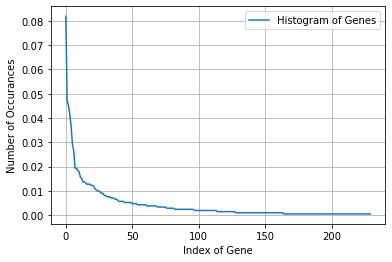

In [33]:
#PDF
s=sum(unique_genes.values)
h=unique_genes.values/s
plt.plot(h,label="Histogram of Genes")

plt.xlabel("Index of Gene")
plt.ylabel("Number of Occurances")
plt.legend()
plt.grid()
plt.show()

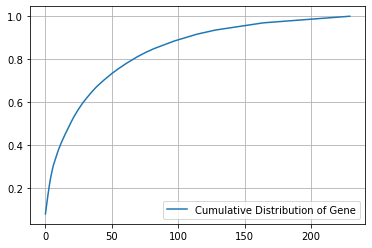

In [34]:
#CDF
cd=n.cumsum(h)
plt.plot(cd,label="Cumulative Distribution of Gene")
plt.grid()
plt.legend()
plt.show()

#We note that the distribution of different genes is skewed in X_train. Top 50 genes cover 75% of data.

<li>Now we will convert our Gene feature into vector form by using both methods.</li>
<h4>1. Response Coding</h4>

In [35]:
alpha=1 #Laplace smoothing parameter
ResponseCoded_Gene_Train=n.array(get_response_coded_features(alpha,"Gene",X_train))
ResponseCoded_Gene_Test=n.array(get_response_coded_features(alpha,"Gene",X_test))
ResponseCoded_Gene_CV=n.array(get_response_coded_features(alpha,"Gene",X_cv))
print(ResponseCoded_Gene_Train.shape)
print(ResponseCoded_Gene_Test.shape)
print(ResponseCoded_Gene_CV.shape)

(2124, 9)
(665, 9)
(532, 9)


<h4>2. One Hot Encoding</h4>

In [36]:
one_hot_encoding= CountVectorizer()
OneHotEncoded_Gene_Train=one_hot_encoding.fit_transform(X_train['Gene'])
OneHotEncoded_Gene_Test=one_hot_encoding.transform(X_test['Gene'])
OneHotEncoded_Gene_cv=one_hot_encoding.transform(X_cv['Gene'])
print(OneHotEncoded_Gene_cv.shape)
print(OneHotEncoded_Gene_Train.shape)
print(OneHotEncoded_Gene_Test.shape)

#Note: We used fit_transform for train and transform for test and cv, reason being when we fit_transform on train, we get 233
#columns. If we do fit_transform on test and cv too, we will get different number of columns in each which will lead to sample
#fields mismatch while predicting probabilities. Thus we use transform to make sure that test and cv has same size as train.
#if used fit_transform
#(532, 142)
#(2124, 233)
#(665, 152)
#error: X has 142 features per sample; expecting 233

(532, 229)
(2124, 229)
(665, 229)


<h3>3.3.1 Predicting y using Feature "Gene"</h3>

<p>Now that we have converted our categorical feature into vector format using two different techniques, now we will use this new feature in a model with class y, to see how much helpful is this feature/ contribution of this feature in predicting yi s. For this we use general purpose classfier called <b>SGDClassifier()</b>. SGD stands for Stochastic Gradient Descent, where the value we pass in loss variable decides which algorithm is applied. loss='hinge' applies linear SVM. Loss='log' applies Logistic Regression. </p>
<p><b>Calibrated Classifier:</b> We do calibration because certain model only predict y as 0 or 1. So in calibration we predict the probabilities of y as 0 and 1. These probabilities are important in computing Log Loss. So we need to predict the probabilites. (See yellow notebook, Miscellaneous Topics). In Calibration model we use sigmoidal method ( sin wave function) or isotonic regression of staircase method. Read notebook for more details.</p>

In [37]:
alpha=[10 ** x for x in range(-6,2)]

log_loss_array_OHE=[] 
for i in alpha:
    
    clf=SGDClassifier(alpha=i,loss='log',random_state=50)
    clf.fit(OneHotEncoded_Gene_Train, y_train)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(OneHotEncoded_Gene_Train,y_train)
    
    predict_y_cv=cali_clf.predict_proba(OneHotEncoded_Gene_cv)
    #print(predict_y_cv)
    log_loss_array_OHE.append(log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))
    print("Alpha=",i," Log Loss=",log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))

Alpha= 1e-06  Log Loss= 1.3185603235381764
Alpha= 1e-05  Log Loss= 1.2102098332906959
Alpha= 0.0001  Log Loss= 1.1969716505917884
Alpha= 0.001  Log Loss= 1.2297320567044747
Alpha= 0.01  Log Loss= 1.3424400098638523
Alpha= 0.1  Log Loss= 1.4519141177000023
Alpha= 1  Log Loss= 1.492748683600127
Alpha= 10  Log Loss= 1.4979202645660008


In [38]:
log_loss_array_RC=[] 
for i in alpha:
    
    clf=SGDClassifier(alpha=i,loss='log',random_state=50)
    clf.fit(ResponseCoded_Gene_Train, y_train)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(ResponseCoded_Gene_Train,y_train)
    
    predict_y_cv=cali_clf.predict_proba(ResponseCoded_Gene_CV)
    #print(predict_y_cv)
    log_loss_array_RC.append(log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))
    print("Alpha=",i," Log Loss=",log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))

Alpha= 1e-06  Log Loss= 1.2924528960562192
Alpha= 1e-05  Log Loss= 1.285256123792058
Alpha= 0.0001  Log Loss= 1.2891476385553327
Alpha= 0.001  Log Loss= 1.3237546282708703
Alpha= 0.01  Log Loss= 1.3529325079573689
Alpha= 0.1  Log Loss= 1.3542547199719581
Alpha= 1  Log Loss= 1.3651074961463376
Alpha= 10  Log Loss= 1.3601260873607257


In [39]:
best_alpha=alpha[n.argmin(log_loss_array_OHE)]
clf=SGDClassifier(alpha=best_alpha,loss='log',penalty='l2',random_state=50)
clf.fit(OneHotEncoded_Gene_Train,y_train)

cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
cali_clf.fit(OneHotEncoded_Gene_Train,y_train)

predict_y_cv=cali_clf.predict_proba(OneHotEncoded_Gene_Train)
print("Cross Validation Log Loss:",log_loss(y_train,predict_y_cv,labels=clf.classes_,eps=1e-15))

predict_y_test=cali_clf.predict_proba(OneHotEncoded_Gene_Test)
print("Test Data Log Loss:",log_loss(y_test,predict_y_test,labels=clf.classes_,eps=1e-15))

Cross Validation Log Loss: 0.9634316019209727
Test Data Log Loss: 1.246319257760244


In [40]:
#ref:
#import pandas as pd   
# making data frame from csv file 
#data = pd.read_csv("employees.csv") 
# creating a bool series from isin() 
#new = data["Gender"].isin(["Male"]) 
# displaying data with gender = male only 
# data[new] 

<p><b>NOTE:</b> We also need to check stability of given feature across train, test and CV. When we say stability, it is possible that train contains A,B,C as categorical values, and CV and Test has, D,E,F and G,H,I as categorical values. In that case our feature is not reliable as we dont know how many of the total category values are covered in test and CV.</p>

In [41]:
test_cov=X_test[X_test["Gene"].isin(list(set(X_train["Gene"])))].shape[0]
cv_cov=X_cv[X_cv["Gene"].isin(list(set(X_train["Gene"])))].shape[0]

print("Out of ",X_test.shape[0]," points in test data ",test_cov," are present in train.")
print("Out of ",X_cv.shape[0], " points in cv data ",cv_cov," are present in train.")

Out of  665  points in test data  637  are present in train.
Out of  532  points in cv data  521  are present in train.


<li><b>CONCLUSION:</b> We can conclude that "Gene" feature is stable across all the data sets.</li>

<h3> Variation Feature </h3>

In [42]:
unique_genes=X_train['Variation'].value_counts()
print("Unique Variations or total categories in X_train:",unique_genes.shape[0])
print(unique_genes.head(10))

Unique Variations or total categories in X_train: 1932
Truncating Mutations         56
Deletion                     48
Amplification                43
Fusions                      27
G12V                          3
Overexpression                2
Promoter Hypermethylation     2
T286A                         2
Q61L                          2
R841K                         2
Name: Variation, dtype: int64


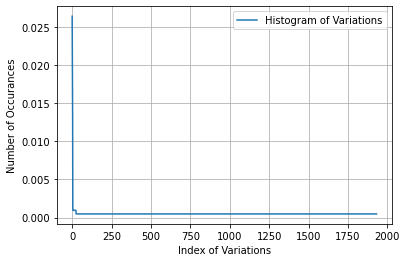

In [43]:
#PDF
s=sum(unique_genes.values)
h=unique_genes.values/s
plt.plot(h,label="Histogram of Variations")

plt.xlabel("Index of Variations")
plt.ylabel("Number of Occurances")
plt.legend()
plt.grid()
plt.show()

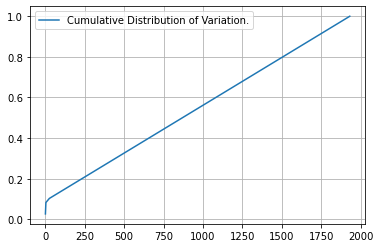

In [44]:
#CDF
cd=n.cumsum(h)
plt.plot(cd,label="Cumulative Distribution of Variation.")
plt.grid()
plt.legend()
plt.show()

#We note that baring the first few variations, most of the variations occures only once or twice.

<h4>1. Response Coding</h4>

In [45]:
alpha=1 #Laplace smoothing parameter
ResponseCoded_Var_Train=n.array(get_response_coded_features(alpha,"Variation",X_train))
ResponseCoded_Var_Test=n.array(get_response_coded_features(alpha,"Variation",X_test))
ResponseCoded_Var_CV=n.array(get_response_coded_features(alpha,"Variation",X_cv))
print(ResponseCoded_Var_Train.shape)
print(ResponseCoded_Var_Test.shape)
print(ResponseCoded_Var_CV.shape)

(2124, 9)
(665, 9)
(532, 9)


<h4>2. One Hot Encoding</h4>

In [46]:
one_hot_encoding= CountVectorizer()
OneHotEncoded_Var_Train=one_hot_encoding.fit_transform(X_train['Variation'])
OneHotEncoded_Var_Test=one_hot_encoding.transform(X_test['Variation'])
OneHotEncoded_Var_cv=one_hot_encoding.transform(X_cv['Variation'])
print(OneHotEncoded_Var_cv.shape)
print(OneHotEncoded_Var_Train.shape)
print(OneHotEncoded_Var_Test.shape)

(532, 1963)
(2124, 1963)
(665, 1963)


In [47]:
alpha=[10 ** x for x in range(-6,2)]

log_loss_array_OHE=[] 
for i in alpha:
    
    clf=SGDClassifier(alpha=i,loss='log',random_state=50)
    clf.fit(OneHotEncoded_Var_Train, y_train)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(OneHotEncoded_Var_Train,y_train)
    
    predict_y_cv=cali_clf.predict_proba(OneHotEncoded_Var_cv)
    #print(predict_y_cv)
    log_loss_array_OHE.append(log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))
    print("Alpha=",i," Log Loss=",log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))

Alpha= 1e-06  Log Loss= 1.74864968039577
Alpha= 1e-05  Log Loss= 1.7332945968551077
Alpha= 0.0001  Log Loss= 1.7265275482094045
Alpha= 0.001  Log Loss= 1.7314084825566054
Alpha= 0.01  Log Loss= 1.7454735238524572
Alpha= 0.1  Log Loss= 1.755308658412424
Alpha= 1  Log Loss= 1.7549812001932288
Alpha= 10  Log Loss= 1.7549248369753825


In [48]:
log_loss_array_RC=[] 
for i in alpha:
    
    clf=SGDClassifier(alpha=i,loss='log',random_state=50)
    clf.fit(ResponseCoded_Var_Train, y_train)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(ResponseCoded_Var_Train,y_train)
    
    predict_y_cv=cali_clf.predict_proba(ResponseCoded_Var_CV)
    #print(predict_y_cv)
    log_loss_array_RC.append(log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))
    print("Alpha=",i," Log Loss=",log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))

Alpha= 1e-06  Log Loss= 2.137986824694005
Alpha= 1e-05  Log Loss= 2.141508818156211
Alpha= 0.0001  Log Loss= 2.0819964039316057
Alpha= 0.001  Log Loss= 1.9653695388128456
Alpha= 0.01  Log Loss= 1.9352247931519262
Alpha= 0.1  Log Loss= 1.932310238138885
Alpha= 1  Log Loss= 1.8277191836907771
Alpha= 10  Log Loss= 1.79187458484076


In [49]:
best_alpha=alpha[n.argmin(log_loss_array_OHE)]
clf=SGDClassifier(alpha=best_alpha,loss='log',penalty='l2',random_state=50)
clf.fit(OneHotEncoded_Var_Train,y_train)

cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
cali_clf.fit(OneHotEncoded_Var_Train,y_train)

predict_y_cv=cali_clf.predict_proba(OneHotEncoded_Var_Train)
print("Cross Validation Log Loss:",log_loss(y_train,predict_y_cv,labels=clf.classes_,eps=1e-15))

predict_y_test=cali_clf.predict_proba(OneHotEncoded_Var_Test)
print("Test Data Log Loss:",log_loss(y_test,predict_y_test,labels=clf.classes_,eps=1e-15))

Cross Validation Log Loss: 0.6830022586706535
Test Data Log Loss: 1.6785485206856534


In [50]:
test_cov=X_test[X_test["Variation"].isin(list(set(X_train["Variation"])))].shape[0]
cv_cov=X_cv[X_cv["Variation"].isin(list(set(X_train["Variation"])))].shape[0]

print("Out of ",X_test.shape[0]," points in test data ",test_cov," are present in train.")
print("Out of ",X_cv.shape[0], " points in cv data ",cv_cov," are present in train.")

Out of  665  points in test data  82  are present in train.
Out of  532  points in cv data  43  are present in train.


<h3> Text Feature</h3>

In [51]:
print(X_train['Text'])

2555    abstract brca1 gene individuals risk breast ov...
761     assessed somatic alleles six receptor tyrosine...
1633    map2k4 encodes dual specificity kinase mitogen...
1185    pi3k pten akt signaling pathway pathway involv...
2175    diffuse large b cell lymphoma dlbcl represents...
                              ...                        
79      generalizations emerge studies protein secreti...
454     pediatric choroid plexus carcinomas cpc adreno...
3139    numerous oncogenes implicated human cancer com...
1259    abstract cancer specific mutations ish2 inter ...
2986    purpose gastrointestinal stromal tumors gist c...
Name: Text, Length: 2124, dtype: object


<li>We will use One Hot Encoding Coding to featurize 'Text' feature.</li>

In [52]:
text_vectorizer=CountVectorizer(min_df=3)
OneHotEncoded_Text_Train=text_vectorizer.fit_transform(X_train['Text'])
OneHotEncoded_Text_Train=normalize(OneHotEncoded_Text_Train,axis=0)

OneHotEncoded_Text_Test=text_vectorizer.transform(X_test['Text'])
OneHotEncoded_Text_Test=normalize(OneHotEncoded_Text_Test,axis=0)

OneHotEncoded_Text_CV=text_vectorizer.transform(X_cv['Text'])
OneHotEncoded_Text_CV=normalize(OneHotEncoded_Text_CV,axis=0)

In [53]:
alpha=[10**x for x in range(-6,2)]

log_loss_array_text=[]
for i in alpha:
    clf=SGDClassifier(alpha=i, loss='log',random_state=50)
    clf.fit(OneHotEncoded_Text_Train,y_train)
    
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(OneHotEncoded_Text_Train,y_train)
    
    predict_y_cv=sig_clf.predict_proba(OneHotEncoded_Text_CV)
    #print(predict_y_cv)
    log_loss_array_text.append(log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))
    print("Alpha=",i," Log Loss=",log_loss(y_cv,predict_y_cv, labels=clf.classes_,eps=1e-15))

Alpha= 1e-06  Log Loss= 1.3475474561268121
Alpha= 1e-05  Log Loss= 1.3296337747662166
Alpha= 0.0001  Log Loss= 1.1770180741739436
Alpha= 0.001  Log Loss= 1.193954223442031
Alpha= 0.01  Log Loss= 1.3091374618055984
Alpha= 0.1  Log Loss= 1.4541668024659082
Alpha= 1  Log Loss= 1.6356882243085777
Alpha= 10  Log Loss= 1.667700730358623


In [54]:
best_alpha=alpha[n.argmin(log_loss_array_text)]
clf=SGDClassifier(alpha=best_alpha,loss='log',penalty='l2',random_state=50)
clf.fit(OneHotEncoded_Text_Train,y_train)

sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(OneHotEncoded_Text_Train,y_train)

predict_y_cv=sig_clf.predict_proba(OneHotEncoded_Text_CV)
print("Cross Validation Log Loss:",log_loss(y_cv,predict_y_cv,labels=clf.classes_,eps=1e-15))

predict_y_test=sig_clf.predict_proba(OneHotEncoded_Text_Test)
print("Test Data Log Loss:",log_loss(y_test,predict_y_test,labels=clf.classes_,eps=1e-15))


Cross Validation Log Loss: 1.1770180741739436
Test Data Log Loss: 1.2372674627533526


In [55]:
#def ResponseCoding_Text(df):
#    new_feature=n.zeros((df.shape[0],9))
#    for i in range(0,9):
#        row_index=0
#        for index,row in df.iterrows():
#            sum_prob=0
#            for word in row['Text'].split():
#                sum_prob+=math.log(((dict_list[i].get(word,0)+10/(total_dict.get(word,0)+90))))
#            new_feature[row_index][i]=math.exp(sum_prob/len(row['Text'].split()))
#            row_index+=1
#    return new_feature        

In [56]:
#ResponseCoded_Text_Train=ResponseCoding_Text(X_train)
#ResponseCoded_Text_CV=ResponseCoding_Text(X_cv)
#ResponseCoded_Text_Test=ResponseCoding_Text(X_test)

<h2>4. Machine Learning Begins </h2>


<p>First we create certain functions to compute log loss and confusion matrix with ease.</p>


In [57]:
def log_loss_and_confusion_matrix(train_x,train_y,test_x,test_y,clf):
    clf.fit(train_x,train_y)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x,train_y)
    pred_y=sig_clf.predict_proba(test_x)
    
    print("Log Loss:",log_loss(test_y,pred_y))
    print("Confusion Matrix\n",confusion_matrix(test_y,n.argmax(pred_y,axis=1)+1))
    
    #Attempt to find number misclassified points
    t=confusion_matrix(test_y,n.argmax(pred_y,axis=1)+1)
    print(n.sum(t))
    print(n.trace(t))
    print((n.sum(t)-n.trace(t))/n.sum(t))

<p> Now we will attach three one hot encoded features into one feature so that we can pass them in our Machine learning models.</p>

In [58]:
OneHot_Gene_Var_Train=hstack((OneHotEncoded_Gene_Train,OneHotEncoded_Var_Train))
OneHot_Gene_Var_Test=hstack((OneHotEncoded_Gene_Test,OneHotEncoded_Var_Test))
OneHot_Gene_Var_CV=hstack((OneHotEncoded_Gene_cv,OneHotEncoded_Var_cv))

In [59]:
Train_X_OneHot=hstack((OneHot_Gene_Var_Train,OneHotEncoded_Text_Train))
CV_X_OneHot=hstack((OneHot_Gene_Var_CV,OneHotEncoded_Text_CV))
Test_X_OneHot=hstack((OneHot_Gene_Var_Test,OneHotEncoded_Text_Test))

print(Train_X_OneHot.shape)
print(Test_X_OneHot.shape)
print(CV_X_OneHot.shape)

Train_y=n.array(list(X_train['Class']))
Test_y=n.array(list(X_test['Class']))
CV_y=n.array(list(X_cv['Class']))

(2124, 55970)
(665, 55970)
(532, 55970)


<h3>4.1 Naive Bayes</h3>

<p>This is kind of base model. It is Naive and it is used as a base model. Also Naive base is good for high dimensional data and one hot encoding produces very high dimensional data.</p>

In [60]:
alpha=[10**x for x in range(-6,2)]
log_loss_array_NB=[]
for i in alpha:
    clf=MultinomialNB(alpha=i)
    clf.fit(Train_X_OneHot,Train_y)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(Train_X_OneHot,Train_y)
    
    CV_pred_proba=cali_clf.predict_proba(CV_X_OneHot)
    log_loss_array_NB.append(log_loss(CV_y,CV_pred_proba,labels=clf.classes_,eps=1e-15))
    print("Alpha:",i,"Log Loss:",log_loss(CV_y,CV_pred_proba))
    

Alpha: 1e-06 Log Loss: 1.2815972482439557
Alpha: 1e-05 Log Loss: 1.2746516800218226
Alpha: 0.0001 Log Loss: 1.2730382695346973
Alpha: 0.001 Log Loss: 1.2719204302999185
Alpha: 0.01 Log Loss: 1.272998967294054
Alpha: 0.1 Log Loss: 1.2768045134321018
Alpha: 1 Log Loss: 1.2946296487920248
Alpha: 10 Log Loss: 1.4191157704755208


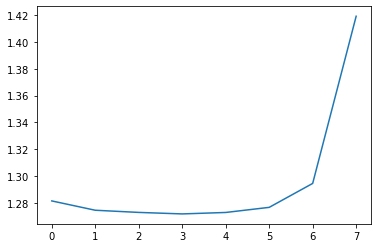

In [61]:
plt.plot(log_loss_array_NB)

In [62]:
best_alpha_NB=alpha[n.argmin(log_loss_array_NB)]
clf=MultinomialNB(alpha=best_alpha_NB)
clf.fit(Train_X_OneHot,Train_y)

cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
cali_clf.fit(Train_X_OneHot,Train_y)

predict_Train=cali_clf.predict_proba(Train_X_OneHot)
predict_CV=cali_clf.predict_proba(CV_X_OneHot)
predict_Test=cali_clf.predict_proba(Test_X_OneHot)

print("Train log loss:",log_loss(Train_y,predict_Train,labels=clf.classes_,eps=1e-15))
print("CV log loss:",log_loss(CV_y,predict_CV,labels=clf.classes_,eps=1e-15))
print("Test log loss:",log_loss(Test_y,predict_Test,labels=clf.classes_,eps=1e-15))

log_loss_and_confusion_matrix(Train_X_OneHot,Train_y,Test_X_OneHot,Test_y,clf)


Train log loss: 0.7989717498085777
CV log loss: 1.2719204302999185
Test log loss: 1.3246446423330631
Log Loss: 1.3246446423330631
Confusion Matrix
 [[ 67   1   1  12  17   1  15   0   0]
 [  3  31   0   1   2   1  53   0   0]
 [  2   0   9   4   1   1   1   0   0]
 [ 30   1   5  73  11   1  16   0   0]
 [  7   1   1   3  23   4   8   0   1]
 [  2   6   0   2   3  34   8   0   0]
 [  2  33  11   1   2   1 141   0   0]
 [  0   0   0   0   0   0   4   0   0]
 [  0   0   0   0   0   0   0   0   7]]
665
385
0.42105263157894735


In [63]:
#code from stackoverflow for finding feature importance. needs review didnt work last time. 1 march 2021.
#neg_class_prob_sorted = NB_optimal.feature_log_prob_[0, :].argsort()
#pos_class_prob_sorted = NB_optimal.feature_log_prob_[1, :].argsort()

#print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
#print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

<h3>4.2 KNN</h3>

KNN has the issue of curse of dimensionality. So one hot coding doesnt work here. We need response coding but we dont know how to handle it with text data. One way of handling is converting to word2vec but we will explore it later. so do remove knn later.

In [64]:
alpha=[1,2,7,11,19,25,50,73,100]
log_loss_KNN=[]

for i in alpha:
    clf=KNeighborsClassifier(n_neighbors=i)
    clf.fit(Train_X_OneHot,Train_y)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(Train_X_OneHot,Train_y)
    
    CV_predict=cali_clf.predict_proba(CV_X_OneHot)
    log_loss_KNN.append(log_loss(CV_y,CV_predict,labels=clf.classes_,eps=1e-15))
    print("Alpha:",i," Log Loss:",log_loss(CV_y,CV_predict,labels=clf.classes_,eps=1e-15))

Alpha: 1  Log Loss: 1.2951645266782763
Alpha: 2  Log Loss: 1.2215625704297002
Alpha: 7  Log Loss: 1.2415808181956307
Alpha: 11  Log Loss: 1.270643733824686
Alpha: 19  Log Loss: 1.3582486604586306
Alpha: 25  Log Loss: 1.397219192467266
Alpha: 50  Log Loss: 1.3732020198357513
Alpha: 73  Log Loss: 1.3595321186628833
Alpha: 100  Log Loss: 1.3319287475579409


<h3>4.3 Logistic Regression</h3>

LR works well with high dimensional data since with many dimensions it is easier to find a hyperplane that will separate our various classes.
We will do LR with class balancing and without class balancing.
<h4>4.3.1 With Class Balancing </h4>

In [65]:
alpha=[10**x for x in range(-6,2)]
log_loss_array=[]

for i in alpha:
    clf=SGDClassifier(loss='log',penalty='l2',alpha=i,class_weight='balanced',random_state=50)
    clf.fit(Train_X_OneHot,Train_y)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(Train_X_OneHot,Train_y)
    
    pred_cv=cali_clf.predict_proba(CV_X_OneHot)
    log_loss_array.append(log_loss(CV_y,pred_cv,labels=clf.classes_,eps=1e-15))
    print("Alpha:",i," Log Loss:",log_loss(CV_y,pred_cv,labels=clf.classes_,eps=1e-15))
    

Alpha: 1e-06  Log Loss: 1.3563805713338557
Alpha: 1e-05  Log Loss: 1.3220652627457672
Alpha: 0.0001  Log Loss: 1.1469171632674466
Alpha: 0.001  Log Loss: 1.1253448904791705
Alpha: 0.01  Log Loss: 1.1815400340297437
Alpha: 0.1  Log Loss: 1.4559296034827833
Alpha: 1  Log Loss: 1.7020894726052571
Alpha: 10  Log Loss: 1.7308410435961976


In [66]:
best_alpha=n.argmin(log_loss_array)
clf=SGDClassifier(class_weight='balanced',penalty='l2',alpha=alpha[best_alpha],loss='log',random_state=50)
clf.fit(Train_X_OneHot,Train_y)

cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
cali_clf.fit(Train_X_OneHot,Train_y)

predict_train=cali_clf.predict_proba(Train_X_OneHot)
print("Train-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(Train_y,predict_train,labels=clf.classes_,eps=1e-15))

predict_cv=cali_clf.predict_proba(CV_X_OneHot)
print("CV-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))

predict_test=cali_clf.predict_proba(Test_X_OneHot)
print("Test-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(Test_y,predict_test,labels=clf.classes_,eps=1e-15))

Train-> Alpha: 0.001  Log Loss: 0.4947891931796721
CV-> Alpha: 0.001  Log Loss: 1.1253448904791705
Test-> Alpha: 0.001  Log Loss: 1.1307296430217082


In [67]:
log_loss_and_confusion_matrix(Train_X_OneHot,Train_y,Test_X_OneHot,Test_y,clf)

Log Loss: 1.1307296430217082
Confusion Matrix
 [[ 78   1   0  17   6   3   9   0   0]
 [  2  30   0   1   0   1  57   0   0]
 [  2   0   5   6   1   0   4   0   0]
 [ 20   0   3  90   8   0  16   0   0]
 [ 12   0   1   6  16   3  10   0   0]
 [  3   3   0   3   2  32  12   0   0]
 [  3  18   3   1   4   1 161   0   0]
 [  0   0   0   0   0   0   2   2   0]
 [  0   0   0   1   0   0   1   0   5]]
665
419
0.3699248120300752


<h4>4.3.2 Without Class Balancing </h4>

In [68]:
alpha=[10**x for x in range(-6,2)]
log_loss_array=[]

for i in alpha:
    clf=SGDClassifier(loss='log',penalty='l2',alpha=i,random_state=50)
    clf.fit(Train_X_OneHot,Train_y)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(Train_X_OneHot,Train_y)
    
    pred_cv=cali_clf.predict_proba(CV_X_OneHot)
    log_loss_array.append(log_loss(CV_y,pred_cv,labels=clf.classes_,eps=1e-15))
    print("Alpha:",i," Log Loss:",log_loss(CV_y,pred_cv,labels=clf.classes_,eps=1e-15))
    

Alpha: 1e-06  Log Loss: 1.316332123890089
Alpha: 1e-05  Log Loss: 1.2835245186089155
Alpha: 0.0001  Log Loss: 1.163096245262511
Alpha: 0.001  Log Loss: 1.152792821743201
Alpha: 0.01  Log Loss: 1.2511580060124543
Alpha: 0.1  Log Loss: 1.3788580039133487
Alpha: 1  Log Loss: 1.5743872900043192
Alpha: 10  Log Loss: 1.615078394053829


In [69]:
best_alpha=n.argmin(log_loss_array)
clf=SGDClassifier(penalty='l2',alpha=alpha[best_alpha],loss='log',random_state=50)
clf.fit(Train_X_OneHot,Train_y)

cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
cali_clf.fit(Train_X_OneHot,Train_y)

predict_train=cali_clf.predict_proba(Train_X_OneHot)
print("Train-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(Train_y,predict_train,labels=clf.classes_,eps=1e-15))

predict_cv=cali_clf.predict_proba(CV_X_OneHot)
print("CV-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))

predict_test=cali_clf.predict_proba(Test_X_OneHot)
print("Test-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(Test_y,predict_test,labels=clf.classes_,eps=1e-15))

Train-> Alpha: 0.001  Log Loss: 0.4947697666278806
CV-> Alpha: 0.001  Log Loss: 1.152792821743201
Test-> Alpha: 0.001  Log Loss: 1.1425394837592497


In [70]:
log_loss_and_confusion_matrix(Train_X_OneHot,Train_y,Test_X_OneHot,Test_y,clf)

Log Loss: 1.1425394837592497
Confusion Matrix
 [[ 78   1   0  19   6   1   9   0   0]
 [  3  31   0   1   0   1  55   0   0]
 [  2   0   5   6   1   0   4   0   0]
 [ 21   0   0  94   6   0  16   0   0]
 [ 12   0   1   6  16   4   9   0   0]
 [  3   3   0   6   2  29  12   0   0]
 [  3  16   0   1   2   1 168   0   0]
 [  0   0   0   0   0   0   2   1   1]
 [  0   0   0   1   0   0   1   0   5]]
665
427
0.35789473684210527


Note: Advantage with class balancing is that less valued classes are better represented. (read more about it.)

<h3>4.4 SVM</h3>

<p>We will be using linear SVM instead of RBF SVM for two reason. First, we dont know which kernal to use. Second, for high dimensional data linear SVM works really well. SVM uses 'hinge' loss instead of 'log loss'. Also linear SVM also has feature importance. In RBF SVM we cannot find feature importance. </p>

In [71]:
alpha=[10**x for x in range(-6,2)]
log_loss_SVM=[]

for i in alpha:
    clf=SGDClassifier(class_weight='balanced',alpha=i,loss='hinge',penalty='l2',random_state=50)
    clf.fit(Train_X_OneHot,Train_y)
    
    cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
    cali_clf.fit(Train_X_OneHot,Train_y)
    
    predict_cv=cali_clf.predict_proba(CV_X_OneHot)
    log_loss_SVM.append(log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))
    print("Alpha:",i," Log Loss:",log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))

Alpha: 1e-06  Log Loss: 1.3424108108120854
Alpha: 1e-05  Log Loss: 1.3271072082917525
Alpha: 0.0001  Log Loss: 1.252206665489337
Alpha: 0.001  Log Loss: 1.1644389737145657
Alpha: 0.01  Log Loss: 1.1775699440338925
Alpha: 0.1  Log Loss: 1.3708314253049714
Alpha: 1  Log Loss: 1.7217294976864366
Alpha: 10  Log Loss: 1.7342924725547872


In [72]:
best_alpha=n.argmin(alpha)

clf=SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha],loss='hinge',penalty='l2',random_state=50)
clf.fit(Train_X_OneHot,Train_y)

cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
cali_clf.fit(Train_X_OneHot,Train_y)

predict_train=cali_clf.predict_proba(Train_X_OneHot)
print("Train-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(Train_y,predict_train,labels=clf.classes_,eps=1e-15))

predict_cv=cali_clf.predict_proba(CV_X_OneHot)
print("CV-> Alpha:",alpha[best_alpha]," Log Loss:",log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))

predict_test=cali_clf.predict_proba(Test_X_OneHot)
print("Test->Alpha:",alpha[best_alpha]," Log Loss:",log_loss(Test_y,predict_test,labels=clf.classes_,eps=1e-15))

Train-> Alpha: 1e-06  Log Loss: 0.830206793052197
CV-> Alpha: 1e-06  Log Loss: 1.3424108108120854
Test->Alpha: 1e-06  Log Loss: 1.3234698845720225


In [73]:
log_loss_and_confusion_matrix(Train_X_OneHot,Train_y,Test_X_OneHot,Test_y,clf)

Log Loss: 1.3234698845720225
Confusion Matrix
 [[ 76   1   0  20   5   1  11   0   0]
 [  2  27   0   2   0   1  59   0   0]
 [  1   0   1   8   1   0   7   0   0]
 [ 24   1   0  87   6   1  18   0   0]
 [  8   1   0  11  12   3  13   0   0]
 [  5   3   0   5   8  21  13   0   0]
 [  3  16   0   2   0   1 169   0   0]
 [  0   0   0   1   0   0   1   2   0]
 [  0   0   0   0   0   0   3   0   4]]
665
399
0.4


<h3> 4.5 Random Forest </h3>
<p>Random forest is an ensemble model, bootstrapped aggregation, with Decision trees as base model. DT works well with less dimensional data. But we will try one hot encoding on RF.
Read about random forest in yellow notebook. It has two variables, n_estimators(number of decision trees in forest), and max_depth( the allowed depth of trees). So we will have to run nested for loops for both the variables.</p>

In [74]:
alpha=[50,100,200,500,1000,2000]
max_depth=[5,10]
rf_log_loss_array=[]

for i in alpha:
    for j in max_depth:
        clf=RandomForestClassifier(n_estimators=i,criterion='gini',max_depth=j,random_state=42,n_jobs=-1)
        clf.fit(Train_X_OneHot,Train_y)
        
        cali_clf=CalibratedClassifierCV(clf,method="sigmoid")
        cali_clf.fit(Train_X_OneHot,Train_y)
        
        predict_cv=cali_clf.predict_proba(CV_X_OneHot)
        rf_log_loss_array.append(log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))
        print("Alpha:",i," Max_Depth:",j,"Log Loss:",log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))

Alpha: 50  Max_Depth: 5 Log Loss: 1.2540341570164795
Alpha: 50  Max_Depth: 10 Log Loss: 1.1989548857988428
Alpha: 100  Max_Depth: 5 Log Loss: 1.2494366364003127
Alpha: 100  Max_Depth: 10 Log Loss: 1.1862331197225295
Alpha: 200  Max_Depth: 5 Log Loss: 1.2461400824792974
Alpha: 200  Max_Depth: 10 Log Loss: 1.1784301030348374
Alpha: 500  Max_Depth: 5 Log Loss: 1.2435161981695229
Alpha: 500  Max_Depth: 10 Log Loss: 1.1712576146894316
Alpha: 1000  Max_Depth: 5 Log Loss: 1.238324931011752
Alpha: 1000  Max_Depth: 10 Log Loss: 1.167715844096492
Alpha: 2000  Max_Depth: 5 Log Loss: 1.2395684864481384
Alpha: 2000  Max_Depth: 10 Log Loss: 1.168791430600463


In [75]:
best_alpha=n.argmin(rf_log_loss_array)
clf=RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)],criterion='gini',max_depth=max_depth[int(best_alpha%2)],random_state=50,n_jobs=-1)
clf.fit(Train_X_OneHot,Train_y)

cali_clf=CalibratedClassifierCV(clf,method='sigmoid')
cali_clf.fit(Train_X_OneHot,Train_y)

predict_train=cali_clf.predict_proba(Train_X_OneHot)
predict_cv=cali_clf.predict_proba(CV_X_OneHot)
predict_test=cali_clf.predict_proba(Test_X_OneHot)

print("For alpha:",alpha[int(best_alpha/2)]," Max_depth:",max_depth[int(best_alpha%2)]," Log Loss Train:",log_loss(Train_y,predict_train,labels=clf.classes_,eps=1e-15))
print("For alpha:",alpha[int(best_alpha/2)]," Max_depth:",max_depth[int(best_alpha%2)]," Log Loss CV:",log_loss(CV_y,predict_cv,labels=clf.classes_,eps=1e-15))
print("For alpha:",alpha[int(best_alpha/2)]," Max_depth:",max_depth[int(best_alpha%2)]," Log Loss Test:",log_loss(Test_y,predict_test,labels=clf.classes_,eps=1e-15))


For alpha: 1000  Max_depth: 10  Log Loss Train: 0.6613838300312369
For alpha: 1000  Max_depth: 10  Log Loss CV: 1.1686593574033843
For alpha: 1000  Max_depth: 10  Log Loss Test: 1.1489383201322565
